In [86]:
import pandas as pd
import numpy as np
import rethinkdb as r
from sklearn.feature_extraction import DictVectorizer
from sklearn import cross_validation, metrics, preprocessing
from tensorflow.contrib import learn
import matplotlib.pyplot as plt
import matplotlib

from demo_backend.models import db

In [21]:
%matplotlib inline

In [9]:
def preprocessing_data():
    conn = r.connect('localhost', '28015')
    cursor = db.table('township_village') \
        .pluck(['county', 'township', 'village', 'scores', 'average_income_per_capita']).run(conn)
    villages = []

    for item in cursor:
        incomes = []
        for income in item['average_income_per_capita']:
            data = {}
            data['avg_income'] = np.sum([
                income['distribution']['below_5k'] * 2500,
                income['distribution']['5k_10k'] * (5000 + 10000) / 2,
                income['distribution']['10k_15k'] * (10000 + 15000) / 2,
                income['distribution']['15k_20k'] * (15000 + 20000) / 2,
                income['distribution']['20k_25k'] * (20000 + 25000) / 2,
                income['distribution']['above_25k'] * 25000,
            ])
            data['year'] = income['year']
            incomes.append(data)

        result = pd.merge(pd.DataFrame(incomes), pd.DataFrame(item['scores']), on='year')
        result['township'] = item['township']
        result['village'] = item['village']
        villages.append(result)

    conn.close()
    return pd.concat(villages)

In [10]:
data = preprocessing_data()

In [11]:
feature_cols = [col for col in data.columns if col not in [u'overall']]
x = data[feature_cols].to_dict(orient='records')
y = data[u'overall'].values

In [12]:
vec = DictVectorizer()
features = vec.fit_transform(x)

In [89]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(features, y)

test_data = data[feature_cols].iloc[0].to_dict()

x_test = vec.transform(test_data)

model.predict(x_test)

In [14]:
x = features.toarray()
y = data[u'overall'].values

In [15]:
# Split dataset into train / test
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.2, random_state=42)

In [16]:
# Scale data (training set) to 0 mean and unit standard deviation.
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)

In [17]:
# Build 2 layer fully connected DNN with 10, 10 units respectively.
regressor = learn.DNNRegressor(hidden_units=[105, 50])

In [103]:
# Fit
regressor.fit(x_train, y_train, steps=5000, batch_size=1)

# Predict and score
y_predicted = regressor.predict(scaler.transform(x_test))
score = metrics.mean_squared_error(y_test, y_predicted)

print('MSE: {0:f}'.format(score))


MSE: 0.084430


In [35]:
d = pd.DataFrame([pd.DataFrame(x_test)[104].values, y_predicted, y_test]).transpose()

In [87]:
matplotlib.style.use('ggplot')

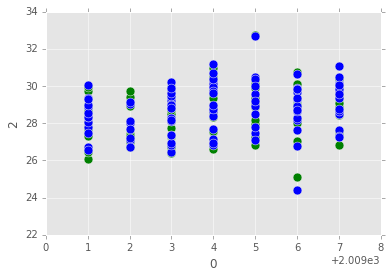

In [102]:
ax = d.plot.scatter(x=0, y=1, s=5*5*3.15, color='Green')
d.plot.scatter(x=0, y=2, s=5*5*3.15, color='Blue', ax=ax)

In [115]:
X = np.random.uniform(0, 10.0, size=100).astype(np.float32)

In [116]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

In [122]:
# Observations
y = f(X).ravel()

In [123]:
dy = 1.5 + 1.0 * np.random.random(y.shape)
dy

array([ 1.7825092 ,  1.69185218,  2.4148118 ,  1.91795763,  2.49662024,
        1.88640413,  1.55496309,  1.94544457,  1.73566659,  1.76866337,
        1.61121146,  1.98230699,  1.88051857,  1.97271466,  1.97765581,
        1.90382401,  2.09602964,  2.21558717,  2.46663035,  2.1019471 ,
        2.48895525,  1.80369134,  1.66787417,  1.92957233,  1.52782253,
        1.83900765,  2.4650818 ,  1.68181136,  2.17439553,  2.15555944,
        1.96674656,  1.68298838,  1.9349935 ,  2.35816217,  2.00784712,
        2.11910845,  1.91165359,  1.70677396,  2.26753313,  2.03258388,
        1.5007323 ,  2.47613335,  2.23334056,  1.56957793,  2.25302224,
        2.27831055,  2.43890345,  1.64578826,  1.79310889,  1.9204544 ,
        1.53511414,  1.57507047,  2.00558879,  1.50809745,  1.70151826,
        1.88790561,  1.77959966,  2.19378354,  2.4317293 ,  2.21897731,
        1.88275818,  2.25406792,  2.07573799,  1.69800852,  2.3452747 ,
        2.17330971,  1.75337875,  2.19815907,  2.16119768,  1.85